<a href="https://colab.research.google.com/github/karam-koujan/dog-vs-cat-classification/blob/main/feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle


In [ ]:
from google.colab import files

files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mlrond","key":"fbae98785636cd498845ad590845bb9b"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/



In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
 !kaggle datasets list

ref                                                                   title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                                 Data Science Salaries 2023 💸                         25KB  2023-04-13 09:55:16          30850        847  1.0              
tawfikelmetwally/automobile-dataset                                   Car information dataset                               6KB  2023-05-28 18:26:48           3243         88  0.9411765        
fatihb/coffee-quality-data-cqi                                        Coffee Quality Data (CQI May-2023)                   22KB  2023-05-12 13:06:39           5569        115  1.0              
mohithsairamreddy/salary-data 

In [ ]:
!kaggle competitions download -c dogs-vs-cats

100% 812M/812M [00:36<00:00, 24.6MB/s]
100% 812M/812M [00:36<00:00, 23.0MB/s]


In [ ]:
!unzip -qq dogs-vs-cats
!unzip -qq train.zip

In [ ]:
import os, shutil, pathlib

In [ ]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("dogs_vs_cats-small")


In [ ]:
def make_subset(subset_name,start_idx,end_idx):
    for category in ("cat","dog"):
       dir = new_base_dir / subset_name / category
       os.makedirs(dir)
       fnames = [f"{category}.{i}.jpg" for i in range(start_idx,end_idx)]
       for fname in fnames :
           shutil.copyfile(src=original_dir/fname,dst=dir/fname)
make_subset("train",0,1000)
make_subset("validation",1000,1500)
make_subset("test",1500,2500)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(new_base_dir/"train",image_size=(180,180),batch_size=32)
validation_dataset = image_dataset_from_directory(new_base_dir/"validation",image_size=(180,180),batch_size=32)
test_dataset = image_dataset_from_directory(new_base_dir/"test",image_size=(180,180),batch_size=32)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
for data_batch, label_batch in train_dataset :
   print("data batch",data_batch.shape)
   print("label batch",label_batch.shape)
   break

data batch (32, 180, 180, 3)
label batch (32,)


In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights = "imagenet",
    include_top = False,
    input_shape = (180,180,3)
)

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
import numpy as np
def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset :
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features),np.concatenate(all_labels)
train_features, train_labels = get_features_and_labels(train_dataset)
validation_features,validation_labels = get_features_and_labels(validation_dataset)
test_features,test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 21ms/step


In [ ]:
inputs = keras.Input(shape= (5,5,512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model = keras.Model(inputs,outputs)

In [ ]:
model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath= "convnet_from_scratch_keras",
        save_best_only=True,
        monitor= "val_loss"
    )
]
history = model.fit(train_features,train_labels,epochs=20,validation_data=(validation_features,validation_labels),callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 2s 20ms/step - loss: 7.0789e-07 - accuracy: 1.0000 - val_loss: 5.7075 - val_accuracy: 0.9770
Epoch 2/20
63/63 [==============================] - 0s 5ms/step - loss: 0.1648 - accuracy: 0.9990 - val_loss: 8.8733 - val_accuracy: 0.9730
Epoch 3/20
63/63 [==============================] - 0s 5ms/step - loss: 0.0303 - accuracy: 0.9995 - val_loss: 5.9593 - val_accuracy: 0.9760
Epoch 4/20
63/63 [==============================] - 0s 5ms/step - loss: 0.1667 - accuracy: 0.9995 - val_loss: 7.2094 - val_accuracy: 0.9770
Epoch 5/20
63/63 [==============================] - 1s 15ms/step - loss: 1.1379e-05 - accuracy: 1.0000 - val_loss: 5.6420 - val_accuracy: 0.9760
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 8.6801e-24 - accuracy: 1.0000 - val_loss: 5.6420 - val_accuracy: 0.9760
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 5.4975e-27 - accuracy: 1.0000 - val_loss: 5.6420 - val_accuracy: 0.9760
Ep

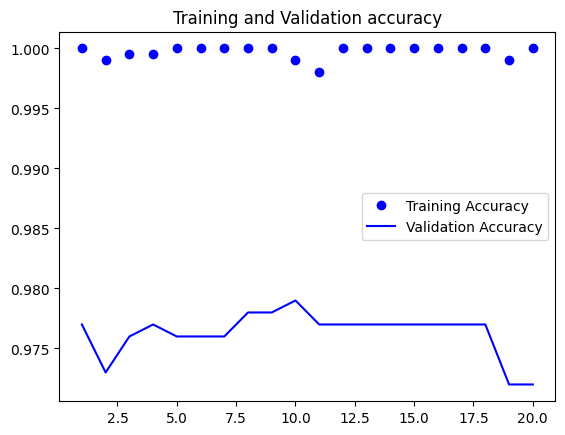

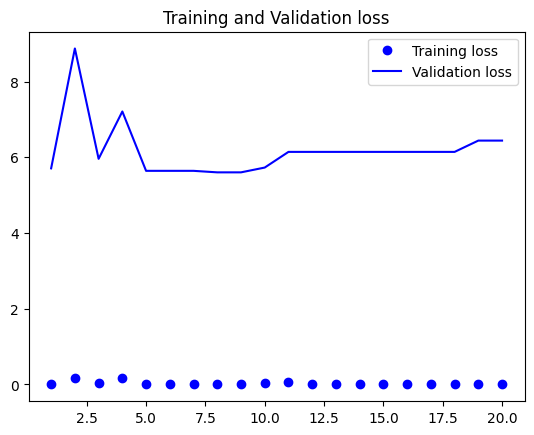

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1,len(accuracy)+1)
plt.plot(epochs,accuracy,"bo",label="Training Accuracy")
plt.plot(epochs,val_accuracy,"b",label="Validation Accuracy")
plt.title("Training and Validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs,loss,"bo",label="Training loss")
plt.plot(epochs,val_loss,"b",label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()